In [375]:
%run pyspark-implementation.ipynb

/Users/amitnarang/movielens/5050/
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    259|     255|     4|874724710|
|    259|     286|     4|874724727|
|    259|     298|     4|874724754|
|    259|     185|     4|874724781|
|    259|     173|     4|874724843|
|    259|     108|     4|874724882|
|    259|     772|     4|874724882|
|    259|     288|     3|874724905|
|    259|     928|     4|874724937|
|    259|     117|     4|874724988|
|    259|     200|     4|874725081|
|    259|     405|     3|874725120|
|    259|    1074|     3|874725264|
|    259|     176|     4|874725386|
|    259|     210|     4|874725485|
|    259|     357|     5|874725485|
|    851|     687|     2|874728168|
|    851|     284|     3|874728338|
|    851|     696|     3|874728338|
|    851|     295|     5|874728370|
+-------+--------+------+---------+
only showing top 20 rows

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+---

22/02/12 08:37:27 WARN CacheManager: Asked to cache already cached data.        
22/02/12 08:37:27 WARN CacheManager: Asked to cache already cached data.
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


1.010619416089037
**Best Model**
  Rank: 150
  MaxIter: 10
  RegParam: 0.1


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{1142, 4.9608097...|
|      2|[{1449, 4.5669127...|
|      3|[{342, 3.4642184}...|
|      4|[{169, 5.404254},...|
|      5|[{169, 4.7577233}...|
|      6|[{1463, 4.3914886...|
|      7|[{612, 4.858188},...|
|      8|[{127, 4.8034077}...|
|      9|[{134, 3.9054456}...|
|     10|[{1449, 4.936683}...|
|     11|[{718, 4.6699853}...|
|     12|[{318, 4.9674087}...|
|     13|[{851, 4.903815},...|
|     14|[{408, 5.098738},...|
|     15|[{459, 4.445922},...|
|     16|[{136, 5.0090284}...|
|     17|[{114, 3.978496},...|
|     18|[{1449, 4.750326}...|
|     19|[{318, 3.8885353}...|
|     20|[{500, 4.031583},...|
+-------+--------------------+
only showing top 20 rows



+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      1|    1142|4.9608097|
|      1|     169|4.9065733|
|      1|     408|4.8603964|
|      1|    1449| 4.780268|
|      1|     114|4.7689214|
|      2|    1449|4.5669127|
|      2|     478| 4.347782|
|      2|    1512|4.3441296|
|      2|     275| 4.293311|
|      2|     190| 4.221725|
+-------+--------+---------+



+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    100|     313|4.2223907|
|    100|     408| 4.011558|
|    100|     169|3.8658636|
|    100|     318|3.8631282|
|    100|     750|3.8311474|
+-------+--------+---------+



1.010619416089037


In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

In [377]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
dir_path = "/Users/amitnarang/movielens/5050/"

In [378]:
stream_df = pd.read_csv(dir_path + 'stream_data.csv').sort_values('timestamp')
test_df = pd.read_csv(dir_path + 'stream_data.csv').sort_values('timestamp')
num_users = max(stream_df['user_id'])
num_movies = max(stream_df['movie_id'])
num_features = 150

In [379]:
user_feature_df = pd.read_csv(dir_path + 'user_features.csv')
movie_feature_df = pd.read_csv(dir_path + 'movie_features.csv')
user_feature_df.dtypes

id           int64
features    object
dtype: object

In [380]:
user_feature_df[user_feature_df['id'] == 1]

,id,features
0,1,"[0.09928978234529495, 0.0, 0.05489214137196541..."


In [381]:
def get_features(df, dim):
    features = dict()
    for row in df.itertuples():
        features[row.id] = np.array(eval(row.features))
    return features

In [382]:
user_features = get_features(user_feature_df, num_users)
movie_features = get_features(movie_feature_df, num_movies)

In [383]:
class ALSStreamingModel():
    
    def __init__(self, als_model, train_data, test_data, num_users, num_movies, num_features, user_vectors, movie_vectors, learning_rate, user_bias_reg, user_feature_reg):
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = num_features
        
        self.global_bias = np.average(train_data['rating'])
        self.user_bias = np.zeros(self.num_users)
        self.user_bias_reg = user_bias_reg
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors = user_vectors
        self.movie_vectors = movie_vectors
        self.user_feature_reg = user_feature_reg
        
        self.als_model = als_model
        self.evaluator = RegressionEvaluator().setMetricName("rmse").setLabelCol("rating").setPredictionCol("prediction")
        
    def train(self):
        mse = []
        als_mse = []
        for row in self.train_data.itertuples():
            curr = time.time()
            if row.Index % 20000 == 0:
                mse.append(self.compute_test_mse())
                als_mse.append(self.compute_als_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            self.step(user_id, movie_id, rating)
            #print(time.time()-curr)
        mse.append(self.compute_test_mse())
        als_mse.append(self.compute_als_mse())
        self.als_mse_record = als_mse
        self.test_mse_record = mse
            
    def update_bias(self, user_id, movie_id, error):
        self.user_bias[user_id] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user_id])
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id] += self.learning_rate * (error * self.movie_vectors[movie_id] - self.user_feature_reg * self.user_vectors[user_id])
        
    def predict_rating(self, user_id, movie_id):
        biases = self.global_bias + self.user_bias[user_id]
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return biases + prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def step(self, user_id, movie_id, rating):
        if user_id not in self.user_vectors:
            self.user_vectors[user_id] = np.random.normal(scale=1./self.num_features, size=self.num_features)
        if movie_id in self.movie_vectors:
            error = self.compute_prediction_error(user_id, movie_id, rating)
            self.update_bias(user_id, movie_id, error)
            self.update_features(user_id, movie_id, error)
            
    def compute_test_mse(self):
        predictions = []
        ratings = []
        count = 0
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            if user_id not in self.user_vectors:
                self.user_vectors[user_id] = np.random.normal(scale=1./self.num_features, size=self.num_features)
            if movie_id in self.movie_vectors:
                count += 1
                predictions.append(self.predict_rating(user_id, movie_id))
                ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            if movie_id in self.movie_vectors:
                predictions.append(self.predict_rating(user_id, movie_id))
                ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_als_mse(self):
        predictions = self.als_model.transform(test_data)
        rmse = self.evaluator.evaluate(predictions)
        return rmse

In [384]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.als_mse_record, label = 'ALS', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [385]:
optimal_learning_rate = .1
optimal_ub_reg = .1
optimal_mb_reg = .01
optimal_uf_reg = .01
optimal_mf_reg = .1
als = ALSStreamingModel(best_model, stream_df, test_df, num_users, num_movies, 150, user_features, movie_features, optimal_learning_rate, optimal_ub_reg, optimal_uf_reg)

In [386]:
als.compute_test_mse()

11.315446538019842

In [387]:
als.compute_als_mse()

1.010619416089037

In [388]:
als.train()

In [389]:
als.compute_test_mse()

1.0966697877099971

In [390]:
als.compute_als_mse()

1.010619416089037

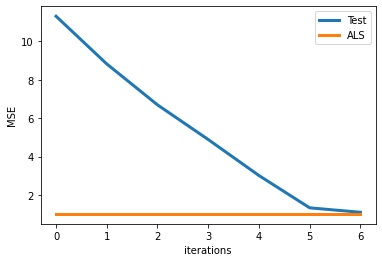

In [391]:
plot_learning_curve(als)